# Training Draft

### Preprocessing

In [1]:
import numpy as np
import tensorflow as tf
from random import randint
from time import time, sleep
from math import sqrt
import matplotlib.pyplot as plt

from process.c_parse import parse_input as c_parse
from process.py_parse import parse_input as py_parse
from db.driver import Driver

%matplotlib inline

DIMENSION = 64

In [2]:
SOURCE, ACCESS = './data/strokes.txt', 'r'

def generate_pixel_matrix(drawing):
    image = np.zeros((DIMENSION, DIMENSION))
    for stroke in drawing:
        for x, y in zip(*stroke):
            image[y][x] = 1
    return image

def display_pixel_matrix(drawing):
    plt.axis('off')
    plt.imshow(generate_pixel_matrix(drawing), cmap='Greys')
    plt.show()

def display_strokes(drawing):
    plt.axis('off')
    plt.gca().invert_yaxis()
    for stroke in drawing:
        plt.plot(*stroke, color='black')
    plt.show()

def collect_runtime_data():
    c, py = [0], [0]
    with open(SOURCE, ACCESS) as doc:
        for line in doc:
            line = line.strip()
            
            start_time = time()
            c_parse(line, normalize=True, RDP=True)
            end_time = time()
            c.append(c[-1] + 1000 * (end_time - start_time))
            
            start_time = time()
            py_parse(line, normalize=True, RDP=True)
            end_time = time()
            py.append(py[-1] + 1000 * (end_time - start_time))
    return [c, py]

def visualize_runtime_difference():
    GRAPH_TITLE = 'Comparison of Total Elapsed Runtime between C and Python Parser'
    X_LABEL = 'Input Size (records)'
    Y_LABEL = 'Time (ms)'
    c, py = collect_runtime_data()
    t = range(len(c))
    plt.xlabel(X_LABEL)
    plt.ylabel(Y_LABEL)
    plt.xticks(t)
    c_trend, = plt.plot(t, c, 'r-', label='C')
    py_trend, = plt.plot(t, py, 'b-', label='Python')
    plt.legend(handles=[c_trend, py_trend])
    plt.title(GRAPH_TITLE)
    plt.show()

In [3]:
driver = Driver()
cat = c_parse(driver.find_by_catagory('cat')[9]['drawing'], normalize=True, RDP=True, epsilon=1.0)

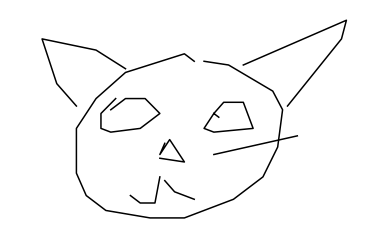

In [4]:
display_strokes(cat)

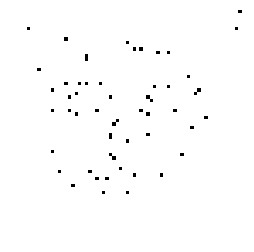

In [5]:
display_pixel_matrix(cat)

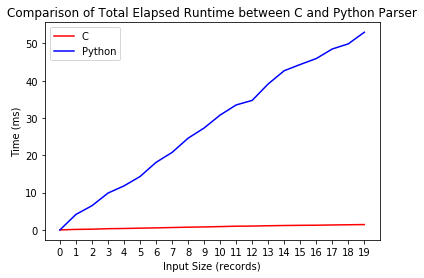

In [6]:
visualize_runtime_difference()

### Expand data

In [7]:
class Line:
    def __init__(self, start, end):
        self.__cache = {}
        self.start = start
        self.end = end
    
    def __cached(function):
        def cached_function(*argv, **kw):
            cache = argv[0].__cache
            token = tuple([function.__name__] + list(argv[1:]))
            if token not in cache:
                cache[token] = function(*argv, **kw)
            return cache[token]
        return cached_function
    
    @__cached
    def __step(self):
        vector = [e - s for s, e in zip(self.start, self.end)]
        if vector[0]:
            vector[1] /= float(abs(vector[0]))
            vector[0] /= abs(vector[0])
        elif vector[1]:
            vector[1] /= abs(vector[1])
        return vector
    
    def __check(self, x, y):
        vector = self.__step()
        if vector[0] > 0:
            return x <= self.end[0]
        elif vector[0] < 0:
            return x >= self.end[0]
        elif vector[1] > 0:
            return y <= self.end[1]
        return y >= self.end[1]
            
    def __iter__(self):
        if self.start == self.end: 
            yield self.start
        else:
            dx, dy = self.__step()
            x, y = self.start
            while self.__check(x, y):
                yield x, int(round(y))
                x, y = x + dx, y + dy

In [8]:
def expand_to_image_matrix(drawing):
    matrix = np.zeros(DIMENSION * DIMENSION)
    for stroke in drawing:
        prev = (stroke[0][0], stroke[1][0])
        for i in xrange(1, len(stroke[0])):
            current = (stroke[0][i], stroke[1][i])
            for x, y in Line(prev, current):
                matrix[y * DIMENSION + x] = 1
            prev = current
    return matrix

In [9]:
CATAGORY_MAP = {
    'airplane': 0,
    'basketball': 1, 
    'cat': 2,
    'diamond': 3,
    'envelope': 4,
    'flower': 5
}

def ImageGenerator(scope=CATAGORY_MAP.keys(), epsilon=0.5):
    cursor = driver.find_all()
    def generator():
        for obj in cursor:
            catagory = np.zeros(len(CATAGORY_MAP))
            catagory[CATAGORY_MAP[obj['word']]] = 1
            drawing = expand_to_image_matrix(c_parse(obj['drawing'], normalize=True, RDP=True, epsilon=epsilon))
            yield drawing, catagory
    return generator

In [10]:
def next_batch_generator(batch_size, sess):
    generator = ImageGenerator()
    ds = tf.data.Dataset.from_generator(generator, output_types=(tf.float32, tf.float32))
    batched_ds = ds.batch(batch_size)
    value = batched_ds.make_one_shot_iterator().get_next()
    return lambda: sess.run(value)

### Softmax

In [11]:
# # Parameters
NUM_CLASSES = 6
BATCH_SIZE = 100
STEP_COUNT = 1000

# sess = tf.InteractiveSession()
# next_batch = next_batch_generator(BATCH_SIZE, sess)

# # tf Graph Input
# X = tf.placeholder(tf.float32, [None, DIMENSION * DIMENSION])
# Y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# # Weights
# W = tf.Variable(tf.zeros([DIMENSION * DIMENSION, NUM_CLASSES]))
# b = tf.Variable(tf.zeros([NUM_CLASSES]))

# sess.run(tf.global_variables_initializer())

# Y = tf.matmul(X,W) + b

# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=Y))
# train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# def test():
#     correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#     test = next_batch()
#     print(accuracy.eval(feed_dict={X: test[0], Y_: test[1]}))

# for index in xrange(STEP_COUNT):
#     if not (index % 100): test()
#     batch, tag = next_batch()
#     train_step.run(feed_dict={X: batch, Y_: tag})

# test()

### CNN

In [12]:
x = tf.placeholder(tf.float32, shape=[None, DIMENSION * DIMENSION], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name='y_')
w = tf.Variable(tf.zeros([DIMENSION * DIMENSION, NUM_CLASSES]), name='w')
b = tf.Variable(tf.zeros([NUM_CLASSES]), name='b')

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 16])
b_conv1 = bias_variable([16])
x_image = tf.reshape(x, [-1, DIMENSION, DIMENSION, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 16, 32])
b_conv2 = bias_variable([32])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([16 * 16 * 32, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 16*16*32])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32, name='k')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 6])
b_fc2 = bias_variable([6])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
tf.identity(y_conv, name='y_conv')

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

STEP = 1000
saver = tf.train.Saver()

sess = tf.Session()
next_batch = next_batch_generator(BATCH_SIZE, sess)
sess.run(tf.global_variables_initializer())

for tensor in [x, y_, y_conv, w, b, keep_prob]:
    tf.add_to_collection('var', tensor)

PHASE = 3

with sess:
    def train(phase):
        for i in xrange(STEP):
            batch, tag = next_batch()
            if i % 100 == 0:
                train_accuracy = accuracy.eval(feed_dict={x: batch, y_: tag, keep_prob: 1.0})
                print('step %d, training accuracy %g' % (i, train_accuracy))
            train_step.run(feed_dict={x: batch, y_: tag, keep_prob: 0.5})
        batch, tag = next_batch()
        print('Phase %d: test accuracy %g' % (phase, accuracy.eval(feed_dict={x: batch, y_: tag, keep_prob: 1.0})))
        saver.save(sess,  './model/sketch_cnn.model', global_step=phase * STEP)
        sleep(60)
    
    for i in xrange(PHASE): train(1 + i)

step 0, training accuracy 0.11
step 100, training accuracy 0.75
step 200, training accuracy 0.78
step 300, training accuracy 0.84
step 400, training accuracy 0.84
step 500, training accuracy 0.82
step 600, training accuracy 0.85
step 700, training accuracy 0.86
step 800, training accuracy 0.87
step 900, training accuracy 0.93
Phase 1: test accuracy 0.9
step 0, training accuracy 0.87
step 100, training accuracy 0.87
step 200, training accuracy 0.84
step 300, training accuracy 0.88
step 400, training accuracy 0.88
step 500, training accuracy 0.93
step 600, training accuracy 0.88
step 700, training accuracy 0.9
step 800, training accuracy 0.93
step 900, training accuracy 0.92
Phase 2: test accuracy 0.89
step 0, training accuracy 0.88
step 100, training accuracy 0.9
step 200, training accuracy 0.84
step 300, training accuracy 0.84
step 400, training accuracy 0.92
step 500, training accuracy 0.9
step 600, training accuracy 0.87
step 700, training accuracy 0.91
step 800, training accuracy 0.